94
Reward after 377 episodes: -195
Reward after 378 episodes: -192
Reward after 379 episodes: -196
Reward after 380 episodes: -190
Reward after 381 episodes: -198
Reward after 382 episodes: -184
Reward after 383 episodes: -191
Reward after 384 episodes: -179
Reward after 385 episodes: -155
Reward after 386 episodes: -182
Reward after 387 episodes: -184
Reward after 388 episodes: -170
Reward after 389 episodes: -166
Reward after 390 episodes: -173
Reward after 391 episodes: -173
Reward after 392 episodes: -176
Reward after 393 episodes: -170
Reward after 394 episodes: -168
Reward after 395 episodes: -170
Reward after 396 episodes: -152
Reward after 397 episodes: -150
Reward after 398 episodes: -159
Reward after 399 episodes: -152
Reward after 400 episodes: -256
Reward after 401 episodes: -154
Reward after 402 episodes: -155
Reward after 403 episodes: -156
Reward after 404 episodes: -154
Reward after 405 episodes: -156
Reward after 406 episodes: -155
Reward after 407 episodes: -152
Rewar

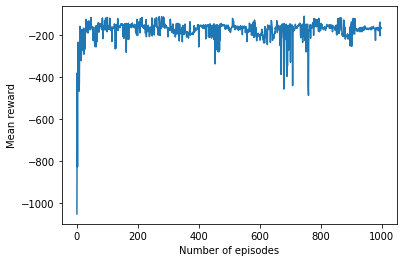

In [1]:
import numpy as np
import math
import argparse
import itertools
import random
from matplotlib import pyplot as plt
import pdb


class MountainCar:
    def __init__(self):
        current_state = None;

    def transition_function(self, state, action):
        x = state[0]
        v = state[1]
        v_n = v + 0.001*action - 0.0025*np.cos(3*x)
        x_n = x + v_n
        if x_n < -1.2:
            x_n = -1.2
            v_n = 0
        elif x_n > 0.5:
            x_n = 0.5
            v_n = 0

        if v_n > 0.07:
            v_n = 0.07
        elif v_n < -0.07:
            v_n = -0.07

        return [x_n, v_n]

    def param_state(self, state, weights):
        param_state = 0
        for i in range(len(state)):
            param_state += state[i]*weights[i]
        return param_state


class ActorCritic:
    def __init__(self, order, epsilon, step_size, lda, num_states=2):
        self.num_states = num_states
        self.epsilon = epsilon
        self.alpha = step_size
        self.lda = lda
        self.mc = MountainCar()
        self.order = order
        self.w = {}
        self.w[-1] = np.zeros(int(math.pow(order+1, num_states)))
        self.w[0] = np.zeros(int(math.pow(order+1, num_states)))
        self.w[1] = np.zeros(int(math.pow(order+1, num_states)))
        self.combns = np.array(list(itertools.product(range(order+1), repeat=num_states)))
        self.x_lim = [-1.2,0.5]
        self.v_lim = [-0.07, 0.07]
        self.actors = [SpikingActor() for i in range(20)]


    def fourier_feature_state(self, state, method='fourier'):
        state_norm = np.zeros(self.num_states)
        state_norm[0] = (state[0]+self.x_lim[1])/(self.x_lim[1]-self.x_lim[0])
        state_norm[1] = (state[1]+self.v_lim[1])/(self.v_lim[1]-self.v_lim[0])

        prod_array = np.dot(self.combns, state_norm)
        features = np.array(np.cos(np.pi*prod_array))

        return features


    def e_greedy_action(self, action_ind):
        prob = (self.epsilon/3)*np.ones(3)
        prob[action_ind] = (1 - self.epsilon) + (self.epsilon/3)
        e_action = np.random.choice(3,1,p=prob)-1
        return int(e_action)


    def run_actor_critic(self, num_episodes, features='fourier'):
        rewards = []
        #theta = np.random.rand(self.num_states)
        #theta = np.zeros(self.num_states)
        theta = np.zeros(int(math.pow(self.order+1, self.num_states)))
        w_v = np.zeros(int(math.pow(self.order+1, self.num_states)))
        alpha = 0.01
        beta = 0.001
        for i in range(num_episodes):
            #if i > 500:
            #    self.alpha = 0.001
            state = np.array([-0.5, 0])
            e_theta = np.zeros_like(theta)
            e_v = np.zeros(int(math.pow(self.order+1, self.num_states)))
            rt = -1; gamma = 1
            count = 0
            sigma = 1
            while state[0] < 0.5:
                # Act using actor
                fourier_state = self.fourier_feature_state(state, features)
                state_param = np.dot(theta, fourier_state)

                o_rates = []
                for k in range(len(self.actors)):
                    o_spikes = self.actors[k].forward(state, count)
                    o_rates.append(o_spikes)
                o_rates = np.array(o_rates)
                action_rates = np.zeros(3)
                for k in range(3):
                    action_rates[k] = sum(o_rates[np.where(o_rates[:,k]==1),k][0])
                action_index = np.argmax(action_rates)
                action = self.e_greedy_action(action_index)

                new_state = self.mc.transition_function(state, action)
                new_state = np.array(new_state)
                fourier_state = self.fourier_feature_state(state, features)
                fourier_new_state = self.fourier_feature_state(new_state, features)

                # Critic update
                e_v = gamma*self.lda*e_v + fourier_state
                v_s = np.dot(w_v, fourier_state)
                v_ns = np.dot(w_v, fourier_new_state)
                delta_t = rt + gamma*v_ns - v_s
                w_v += alpha*delta_t*e_v

                # Actor update
                for k in range(len(self.actors)):
                    self.actors[k].update_weights(delta_t, state, action+1)

                #print(state, new_state)
                state = new_state
                count += 1
                if count > 5000:
                    break
            #pdb.set_trace()
            if count > 5000:
                continue
            #if i%20 == 0 or i == 99:
            print("Reward after %s episodes: %s" %(i, -count))
            rewards.append(-1*count)
        return rewards



class SpikingActor():
    def __init__(self):
        self.inputs = 20
        self.hidden = 5
        self.outputs = 3
        self.ih_weights = np.random.rand(self.hidden, self.inputs)
        self.ih_bias = np.random.rand(self.hidden)
        self.ho_weights = np.random.rand(self.outputs, self.hidden)
        self.ho_bias = np.random.rand(self.outputs)
        self.alpha = 0.1
        self.h_spikes = np.ones(self.hidden)
        self.o_spikes = np.ones(self.outputs)
        self.in_spikes = np.ones(self.inputs)
        self.hz = np.zeros(self.hidden)
        self.oz = np.zeros(self.outputs)

    def input_coding(self, state):
        maps = list(itertools.combinations(range(int(self.inputs*0.5)), r=5))
        state_code = -1*np.ones(self.inputs)
        xb = int(self.inputs*0.5*(state[0] + 1.2)/2.4)
        vb = int(self.inputs*0.5*(state[1] + 0.07)/0.14) 
        state_code[list(maps[xb])] = 1
        state_code[list(np.array((maps[vb])) + int(self.inputs*0.5))] = 1
        return state_code


    def forward(self,state,count):
        inputs = self.input_coding(state)
        self.in_spikes = inputs

        z = np.matmul(self.ih_weights, inputs) + self.ih_bias
        pr = 1/(1 + np.exp(-2*z))
        self.h_spikes = (pr > np.random.rand(self.hidden)).astype(int)
        self.h_spikes = 2*self.h_spikes - 1
        self.hz = np.exp(z) + np.exp(-z)


        zo = np.matmul(self.ho_weights, self.h_spikes) + self.ho_bias
        po = 1/(1 + np.exp(-2*zo + 1 ))
        self.o_spikes = (po > np.random.rand(self.outputs)).astype(int)
        self.o_spikes = 2*self.o_spikes - 1
        self.oz = np.exp(zo) + np.exp(-zo)


        return self.o_spikes

    def update_weights(self, tderror, state, action):
        #print(state, action, self.h_spikes, self.o_spikes, tderror)

        h_grad = self.h_spikes
        h_grad[np.where(self.h_spikes) == -1] = -2*self.hz
        h_grad[np.where(self.h_spikes) == 1] = 2*(1-self.hz)
        self.ih_bias += self.alpha*tderror*h_grad
        self.ih_weights += self.alpha*tderror*np.outer(h_grad, self.in_spikes)
        #pdb.set_trace()

        o_grad = self.o_spikes
        o_grad[np.where(self.o_spikes) == -1] = -2*self.oz
        o_grad[np.where(self.o_spikes) == 1] = 2*(1-self.oz)

        self.ho_bias += self.alpha*tderror*o_grad

        for i in range(self.outputs):
            if i == action:
                for j in range(self.hidden):
                    self.ho_weights[i,j] += self.alpha*tderror*o_grad[i]*self.h_spikes[j]
            if i != action and tderror > 0:
                for j in range(self.hidden):
                    self.ho_weights[i,j] += self.alpha*tderror*o_grad[i]*self.h_spikes[j]



class Args:
    algorithm = 'ac'
    features = 'fourier'
    selection = 'egreedy'
    num_trials = 1
    num_episodes = 1000
    plot = True


if __name__ == "__main__":

    args = Args()

    rewards_trials = []

    step_size = 0.01
    epsilon = 0.1
    lda = 0.5


    for i in range(int(args.num_trials)):
        print('Trial:', i)
        td_cp = ActorCritic(order=4, epsilon=epsilon, step_size=step_size, lda=lda)
        rewards = td_cp.run_actor_critic(int(args.num_episodes), features='fourier')
        rewards_trials.append(rewards)

    print("Maximum reward reached at the end of 1000 episodes : ", np.mean(rewards_trials, axis=0)[-1] )

    if args.plot:
        episodes = np.linspace(0,int(args.num_episodes)-1,int(args.num_episodes))
        rewards_mean = np.mean(rewards_trials, axis=0)
        rewards_std = np.std(rewards_trials, axis=0)
        plt.errorbar(episodes, rewards_mean, rewards_std)
        plt.ylabel('Mean reward')
        plt.xlabel('Number of episodes')
        plt.show()

In [55]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

Rm = rewards_mean
mean_rewards = []
std_rewards = []
for i in range(len(Rm)):
    mean_rewards.append(np.mean(Rm[:(i+1)]))
    std_rewards.append(np.std(Rm[:(i+1)]))
mean_rewards = np.array(mean_rewards)
std_rewards = np.array(std_rewards)

p0 = figure(
    title = "Rewards (Mountain car)",
    x_axis_label = "Episodes",
    y_axis_label = "Rewards"
)
p0.line(x=episodes, y=Rm, line_width=2)

p1 = figure(
    title = "Mean rewards (Mountain car)",
    x_axis_label = "Episodes",
    y_axis_label = "Mean Rewards"
)
p1.line(x=episodes, y=mean_rewards, line_width=2)

p2 = figure(
    title = "Standard deviation of rewards (Mountain car)",
    x_axis_label = "Episodes",
    y_axis_label = "Standard Deviation of Rewards"
)
p2.line(x=episodes, y=std_rewards, line_width=2, color='red')

Loading BokehJS ...

GlyphRenderer(id='4933', ...)

In [56]:
show(p0)

In [57]:
show(p1)

In [58]:
show(p2)